# CNN Example
Examplary PyTorch implementation of a convolutional neural network for image classification on the MNIST dataset.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

data_root = "/home/space/datasets"

In [2]:
# Query the GPU
print(f"There are {torch.cuda.device_count()} GPUs available.")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

There are 4 GPUs available.
Tesla P100-PCIE-12GB


# Define network architecture
We use the layer types `nn.Conv2d` and `nn.Linear` with the following signatures:
* `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)`
* `nn.Linear(in_features, out_features, bias=True)`

Pooling is done by `F.max_pool2d(input, kernel_size)`.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        x = x.view(-1, 20 * 4 * 4)  # Reshape to vector
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Data loading

In [4]:
# Setup input transformation
batch_size = 128
transformation = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))  # Standardization - grayscale img so 1 channel
                   ])

# Setup data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_root, train=True, transform=transformation),
    batch_size=batch_size
)

## Setup model and optimizer

In [5]:
device = torch.cuda.current_device()
print(f"Using GPU {device}.")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

Using GPU 0.


## Training

In [6]:
def train_epoch(model, device, train_loader, optimizer):
    # Set network to training mode
    model.train()
    
    # Iterate over dataset
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU
        data, target = data.to(device), target.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Compute output
        output = model(data)
        
        # Compute crossentropy loss
        loss = F.nll_loss(output, target)
        
        # Compute gradient
        loss.backward()
        
        # Perform gradient descent
        optimizer.step()
        
        # Track losses
        losses.append(loss.item())
    # Return loss at end of epoch
    return losses

In [7]:
losses = list()
for epoch in tqdm(range(5)):
    epoch_losses = train_epoch(model, device, train_loader, optimizer)
    print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
    losses.extend(epoch_losses)

 20%|██        | 1/5 [00:08<00:35,  8.90s/it]

Average loss in epoch 0: 0.69532


 40%|████      | 2/5 [00:17<00:26,  8.89s/it]

Average loss in epoch 1: 0.15942


 60%|██████    | 3/5 [00:26<00:17,  8.89s/it]

Average loss in epoch 2: 0.11022


 80%|████████  | 4/5 [00:35<00:08,  8.88s/it]

Average loss in epoch 3: 0.08893


100%|██████████| 5/5 [00:44<00:00,  8.93s/it]

Average loss in epoch 4: 0.07637


In [8]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


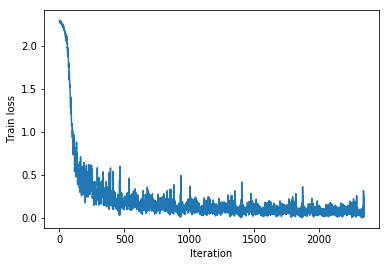

In [9]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()